In [1]:
import numpy as np
import pandas as pd
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras

import os
import skimage.io as io
import skimage.transform as trans

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.initializers import *
from keras.callbacks import *
from keras import backend as K

import random as rn

from keras.constraints import *

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using TensorFlow backend.


/kaggle/input/abstraction-and-reasoning-challenge/sample_submission.csv
/kaggle/input/abstraction-and-reasoning-challenge/training/b91ae062.json
/kaggle/input/abstraction-and-reasoning-challenge/training/b27ca6d3.json
/kaggle/input/abstraction-and-reasoning-challenge/training/7f4411dc.json
/kaggle/input/abstraction-and-reasoning-challenge/training/9d9215db.json
/kaggle/input/abstraction-and-reasoning-challenge/training/11852cab.json
/kaggle/input/abstraction-and-reasoning-challenge/training/82819916.json
/kaggle/input/abstraction-and-reasoning-challenge/training/23b5c85d.json
/kaggle/input/abstraction-and-reasoning-challenge/training/a699fb00.json
/kaggle/input/abstraction-and-reasoning-challenge/training/d90796e8.json
/kaggle/input/abstraction-and-reasoning-challenge/training/b60334d2.json
/kaggle/input/abstraction-and-reasoning-challenge/training/a5f85a15.json
/kaggle/input/abstraction-and-reasoning-challenge/training/6c434453.json
/kaggle/input/abstraction-and-reasoning-challenge/tr

# Load

In [2]:
path = Path('/kaggle/input/abstraction-and-reasoning-challenge')
train_path = path / 'training'
test_path = path / 'test'
evalu_path = path / 'evaluation'
train_dir = sorted(os.listdir(train_path))
evalu_dir = sorted(os.listdir(evalu_path))
test_dir = sorted(os.listdir(test_path))

def get_sub(task_filename):
    with open(task_filename, 'r') as f:
        task = json.load(f)
    return task

def get_data_list(dir_path, dir_name, nums=None):
    dir_data = dir_name
    
    # 引数がデータ数より多い場合、指定がない場合の処理
    if not nums or nums>len(dir_data):
        nums = len(dir_data)
    
    # 格納するリスト初期化
    train_in_list = []
    train_out_list = []
    train_label_list = []
    test_in_list = []
    test_out_list = []
    test_label_list = []
    # ロード
    for num in range(nums):
        for t in ["train", "test"]:
            sub = get_sub(dir_path/dir_name[num])[t]
            for num_sub in range(len(sub)):
                # train
                if t=="train":
                    train_in_list.append(sub[num_sub]["input"])
                    if "output" in sub[num_sub].keys():
                        train_out_list.append(sub[num_sub]["output"])
                    train_label_list.append(num)
                # test
                if t=="test":
                    test_in_list.append(sub[num_sub]["input"])
                    if "output" in sub[num_sub].keys():
                        test_out_list.append(sub[num_sub]["output"])
                    test_label_list.append(num)
                    
    train_dic = {"in_list":train_in_list, "out_list":train_out_list, "label_list":train_label_list}
    test_dic = {"in_list":test_in_list, "out_list":test_out_list, "label_list":test_label_list}
    
    return train_dic, test_dic

train_train_dic, train_test_dic = get_data_list(train_path, train_dir)
test_train_dic, test_test_dic = get_data_list(test_path, test_dir)
evalu_train_dic, evalu_test_dic = get_data_list(evalu_path, evalu_dir)

# ラベルの取得

In [3]:
train_train_label_array = np.array(train_train_dic["label_list"])
train_test_label_array = np.array(train_test_dic["label_list"])
test_train_label_array = np.array(test_train_dic["label_list"])
test_test_label_array = np.array(test_test_dic["label_list"])

# sample_sub

In [4]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

sample_sub = pd.read_csv(path/'sample_submission.csv')
sample_sub = sample_sub.set_index('output_id')
sample_sub.head()

,output
output_id,
00576224_0,|32|78| |32|78| |00|00|
009d5c81_0,|00000000000000|00000888888888|00000800080808|...
00dbd492_0,|00000000000222220000|02222222220200020000|020...
03560426_0,|0000000000|0000000000|0000000000|0000000000|0...
05a7bcf2_0,|000000000020000000080000000000|00000000002220...


# 数字毎にチャネル化

In [5]:
def change_ndim(lists):
    for n, data_list in enumerate(lists):
        data = np.array(data_list)
        # 数字にあったチャネルのセルを１にする
        for i in range(10):
             # テンプレarray 該当セルを１
            data_zeros = np.zeros((data.shape[0], data.shape[1]))
            data_zeros[np.where(data==i)] = 1
            # チャネル次元を追加してマージ
            if i==0:
                data_nch = data_zeros[:, :, np.newaxis]
            else:
                data_nch = np.concatenate([data_nch, data_zeros[:, :, np.newaxis]], axis=-1)
        # バッチ次元を追加してマージ
        if n==0:
            data_nb = data_nch[np.newaxis, :, :, :]
        else:
            data_nb = np.concatenate([data_nb, data_nch[np.newaxis, :, :, :]], axis=0)
        
    return data_nb

# チャネル化を戻す
def re_chanel_ndim(array):
    for n, data_array in enumerate(array):
        data_zeros = np.zeros((data_array.shape[0], data_array.shape[1]))
        for i in range(data_array.shape[-1]):
            data_zeros[np.where(data_array[:, :, i]==1)] = i
        if n==0:
            data_re = data_zeros[np.newaxis, :, :]
        else:
            data_re = np.concatenate([data_re, data_zeros[np.newaxis, :, :]], axis=0)
            
    return data_re

# model

In [6]:
# kerasのランダム初期値を固定
def seed_everything(seed=0):
    rn.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [7]:
def test_task1(input_size = (None, None,10)):
#     K.clear_session( )
    # 初期値固定
    seed_everything(0)
    
    # モデル
    #######################################
    # 元画像からoutの各２✖︎２を算出
    inputs = Input(input_size)
    
    for ch in range(10):
        for n in range(3):
            for m in range(3):
                one = Lambda(lambda x: x[:, :, :, ch:ch+1], output_shape=(None, None, 1))(inputs)    # 元画像から１CH選択
                
                part = Conv2D(2, 1, activation = 'relu', padding = 'same', kernel_initializer = 'ones')(one)    # conv 2, 1　１回
                part = Conv2D(1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'ones')(part)    # conv1, 1、1CH化
                # 中央の２行　逆順########
                if n==1 :
                    part = Lambda(lambda x: K.reverse(x, 2),)(part)
                
                if m==0:
                    row = part
                else:
                    row = Concatenate(axis=2)([row, part])

            if n==0:
                merge = row
            else:
                merge = Concatenate(axis=1)([merge, row])
                
        if ch==0:
            ch_merge = merge
        else:
            ch_merge = Concatenate(axis=-1)([ch_merge, merge])
    
    outputs = Activation('softmax')(ch_merge)
    #######################################
    
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'sparse_categorical_crossentropy',    # sparse_categorical or binary
                  metrics = ['sparse_categorical_accuracy'], loss_weights=None, sample_weight_mode="temporal")
#     model.summary()
       
    # 早期打ち切り
    early_stopping = EarlyStopping(monitor='val_loss',    # val_loss, val_sparse_categorical_accuracy ?????
                                                   min_delta=0, patience=50, verbose=0, mode='auto', restore_best_weights=True)
    # 学習
    index = np.where(test_train_label_array==0)
    start, end = index[0][0], index[0][-1] + 1
    
    x = change_ndim(test_train_dic["in_list"][start:end])
    y = np.array(test_train_dic["out_list"][start:end]).copy()[:, :, :, np.newaxis]
    
    model_history = model.fit(
                        x[:-1, :, :, :],
                        y[:-1, :, :, :],    # test用
                        epochs=50,    # まずは過剰な学習で確認
                        batch_size=x.shape[0],    # 全サンプルで更新
                        verbose=0,
                        validation_data=(
                                         x[-1:, :, :, :],
                                         y[-1:, :, :, :],    # test用
                                         ),
                        callbacks=[
                                         early_stopping
                                        ]
                        )

    return model, model_history

In [8]:
def test_task2(pretrained_weights = None,input_size = (None, None,10)):
#     K.clear_session( )
    # 初期値固定
    seed_everything(0)
    
    # モデル
    #######################################
    # 色を変える画像、色を決める画像それぞれのchを抜き出しアテンション
    inputs = Input(input_size)
    
    for n in range(10):
        eight = Lambda(lambda x: x[:, :, :, 8:9], output_shape=(None, None, 1))(inputs)    # 色変える画像のch
        
        one = Lambda(lambda x: x[:, :, :, 1:2], output_shape=(None, None, 1))(inputs)    # 色を決める形状のch
        one = Conv2D(1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'ones')(one)    # conv 1, 3　形を読み取る
        one = Conv2D(1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'ones')(one)
        one = GlobalMaxPooling2D()(one)    # 各chに対する「アテンション」に使用
        
        ch = Multiply()([eight,one])  # アテンションと乗算 
        
        if n==0:
            merge = ch
        else:
            merge = Concatenate(axis=-1)([merge, ch])
    
    outputs = Activation('softmax')(merge)
    #######################################
    
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'sparse_categorical_crossentropy',    # sparse_categorical or binary
                  metrics = ['sparse_categorical_accuracy'], loss_weights=None, sample_weight_mode="temporal")
#     model.summary()
       
    # 早期打ち切り
    early_stopping = EarlyStopping(monitor='val_loss',    # val_loss, val_sparse_categorical_accuracy ?????
                                                   min_delta=0, patience=1000, verbose=0, mode='auto', restore_best_weights=True)
    # 学習
    index = np.where(test_train_label_array==1)
    start, end = index[0][0], index[0][-1] + 1
    
    x = change_ndim(test_train_dic["in_list"][start:end])
    y = np.array(test_train_dic["out_list"][start:end]).copy()[:, :, :, np.newaxis]
    
    model_history = model.fit(
                        x[:-1, :, :, :],
                        y[:-1, :, :, :],    # test用
                        epochs=2000,    # まずは過剰な学習で確認    ###############################   he_normal ??????
                        batch_size=x.shape[0],    # 全サンプルで更新
                        verbose=0,
                        validation_data=(
                                         x[-1:, :, :, :],
                                         y[-1:, :, :, :],    # test用
                                         ),
                        callbacks=[
                                         early_stopping
                                        ]
                        )

    return model, model_history

In [9]:
def test_task3(x_list, y_list=None):
    pred_list = []
    for x in x_list:
        # バッチ次元の削除
        x = x[0]
        # 探索
        for num, ch in zip([5, 7, 9], [8, 4, 3]):
            # 初期化
            scan = num*4-3
            width = (num-3)//2    # 1, 2, 3
            # 探索
            one = np.ones((num, num))
            dummy = np.zeros_like(x[:, :, 0])
            for row in range(x.shape[0]-num+1):
                for col in range(x.shape[1]-num+1):
                    dummy[(num-1)//2+row, (num-1)//2+col] = (x[row:row+num, col:col+num, 2]*one).sum()    # 元画像の輪郭に対してサーチ
            
            rows, cols = np.where(dummy==scan)
            for row, col in zip(rows, cols):
                x[row-width:row+width+1, col-width:col+width+1, ch] = 0.75
                x[row-width:row+width+1, col-width:col+width+1, 0] = 0
        
        pred_list.append(x.argmax(axis=-1))
    
    return pred_list

# # train
# train_pred_list = test_task3(x_train_list, y_sparse_train_list)
# # test
# test_pred_list = test_task3(x_val_list)

In [10]:
# モデルの学習
model1, model1_history = test_task1()
model2, model2_history = test_task2()

# 予測
label = 0
for num, data_list in enumerate(test_test_dic["in_list"]):
    
    x = change_ndim(test_test_dic["in_list"][num:num+1])
    pred1 = model1.predict(x).argmax(axis=-1)[0].astype(int).tolist()
    pred2 = model2.predict(x).argmax(axis=-1)[0].astype(int).tolist()
    x_list = [(change_ndim(test_test_dic["in_list"][num:num+1]))]
    pred3 = test_task3(x_list)[0].astype(int).tolist()    # list
    
    label = test_test_label_array[num]
    task_num = 0
    if label==test_test_label_array[num-1] and num!=0:
        task_num = 1
    sample_sub.loc[f'{test_dir[label][:-5]}_{task_num}', 'output'] = flattener(pred1) + " "+ flattener(pred2) + " "+ flattener(pred3)

In [11]:
sample_sub.head()

,output
output_id,
00576224_0,|323232|787878|232323|878787|323232|787878| |0...
009d5c81_0,|000000000000000000000000000000000000000000|00...
00dbd492_0,|000000000002222200000000000000022222000000000...
03560426_0,|000000000000000000000000000000|00000000000000...
05a7bcf2_0,|000000000020000000080000000000000000000020000...


In [12]:
sample_sub.to_csv('submission.csv')

In [19]:
#モデル可視化

# # !brew install graphviz
# # !pip install pydot_ng
# import pydot_ng as pydot
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# from keras.utils import plot_model

# keras.utils.vis_utils.pydot = pydot

# plot_model(model1, to_file='cnn.png', show_shapes=True)
# SVG(model_to_dot(model1, show_shapes=True).create(prog='dot', format='svg'))

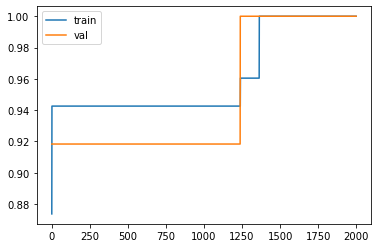

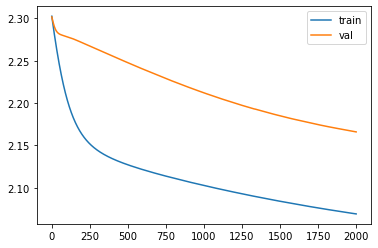

In [21]:
# 精度の推移
plt.plot(model2_history.history["sparse_categorical_accuracy"])
plt.plot(model2_history.history["val_sparse_categorical_accuracy"])
plt.legend(["train", "val"])
plt.show()

# ロスの推移
plt.plot(model2_history.history["loss"])
plt.plot(model2_history.history["val_loss"])
plt.legend(["train", "val"])
plt.show()

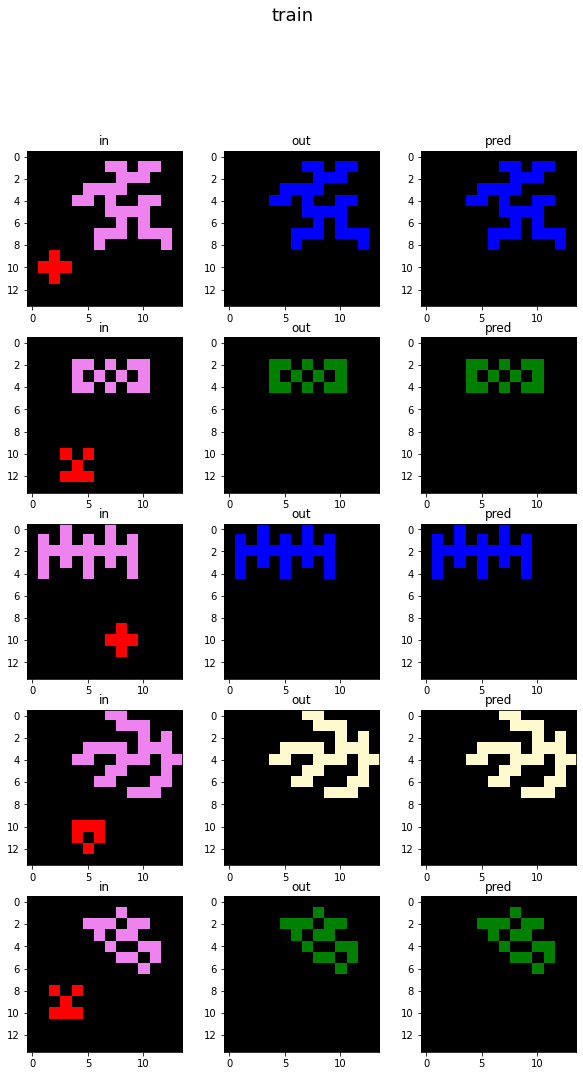

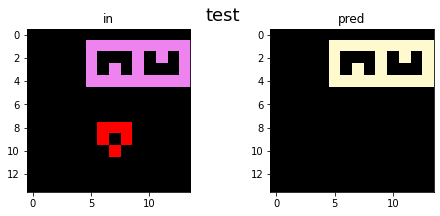

In [28]:
# 予測結果の可視化、答え合わせ
# 数字毎の色の指定
cmap = colors.ListedColormap(['Black', 'Red', 'Blue', 'Green', 'LightGreen',
                               'Brown', 'Yellow', 'LemonChiffon', 'Violet', "orangered"])
# 入力数字「０−９」に対応するため標準化
norm = colors.Normalize(vmin=0, vmax=9)

# データ準備
index = np.where(test_train_label_array==1)
start, end = index[0][0], index[0][-1] + 1
x_train = change_ndim(test_train_dic["in_list"][start:end])
y_train = change_ndim(test_train_dic["out_list"][start:end])
x_test = change_ndim(test_test_dic["in_list"][1:2])

# train
plt.figure(figsize=(10, x_train.shape[0]*5)).suptitle("train", size=18)
for n in range(x_train.shape[0]):
    # in
    plt.subplot(x_train.shape[0]+1, 3, 3*(n+1)-2)
    plt.imshow(re_chanel_ndim(x_train)[n], cmap=cmap, norm=norm)
    plt.title('in')
    # out
    plt.subplot(x_train.shape[0]+1, 3, 3*(n+1)-1)
    plt.imshow(re_chanel_ndim(y_train)[n], cmap=cmap, norm=norm)
    plt.title('out')
    # pred
    plt.subplot(x_train.shape[0]+1, 3, 3*(n+1))
    plt.imshow(np.array(model2.predict(x_train).argmax(axis=-1)[n]), cmap=cmap, norm=norm)
    plt.title('pred')
plt.show()

# test
plt.figure(figsize=(8, 3)).suptitle("test", size=18)
# in
plt.subplot(1, 2, 1)
plt.imshow(re_chanel_ndim(x_test)[0], cmap=cmap, norm=norm)
plt.title('in')
# pred
plt.subplot(1, 2, 2)
plt.imshow(np.array(model2.predict(x_test).argmax(axis=-1)[0]), cmap=cmap, norm=norm)
plt.title('pred')
plt.show()